<a href="https://colab.research.google.com/github/alesha-ofc-he/Kassymbekov_Merekeyev_DL_Project/blob/main/Drone_Section_3_Foundations_of_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1: Imports & Data Preparation


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os


np.random.seed(69)

# --- 1. Data Loader (Pure NumPy) ---
if not os.path.exists('cifar-10-batches-py'):
    print("Downloading CIFAR-10...")
    !wget -q https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    !tar -xzf cifar-10-python.tar.gz

def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')

def load_data_subset():
    print("Loading data...")
    batch1 = unpickle('cifar-10-batches-py/data_batch_1')
    test_batch = unpickle('cifar-10-batches-py/test_batch')

    # Raw Data
    X_train_raw = batch1[b'data']
    y_train_raw = np.array(batch1[b'labels'])
    X_test_raw = test_batch[b'data']
    y_test_raw = np.array(test_batch[b'labels'])

    # --- SUBSET SELECTION (Crucial for NumPy performance) ---
    # Using 5,000 training samples and 500 test samples
    train_limit = 5000
    test_limit = 500

    X_train_raw = X_train_raw[:train_limit]
    y_train_raw = y_train_raw[:train_limit]
    X_test_raw = X_test_raw[:test_limit]
    y_test_raw = y_test_raw[:test_limit]

    # --- PREPROCESSING ---
    # Reshape to (N, 32, 32, 3)
    X_train_rgb = X_train_raw.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test_rgb = X_test_raw.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    # Grayscale conversion
    weights = np.array([0.299, 0.587, 0.114])
    X_train_gray = np.dot(X_train_rgb, weights)
    X_test_gray = np.dot(X_test_rgb, weights)

    # Add channel dimension: (N, 32, 32) -> (N, 32, 32, 1)
    # CNNs expect 4D input
    X_train = (X_train_gray / 255.0)[:, :, :, np.newaxis]
    X_test = (X_test_gray / 255.0)[:, :, :, np.newaxis]

    # One-Hot Encoding
    def to_one_hot(y, k=10):
        one_hot = np.zeros((len(y), k))
        one_hot[np.arange(len(y)), y] = 1
        return one_hot

    Y_train = to_one_hot(y_train_raw)
    Y_test = to_one_hot(y_test_raw)

    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = load_data_subset()

print(f"Subset Loaded!")
print(f"Train Shape: {X_train.shape} (N, H, W, C)")
print(f"Test Shape: {X_test.shape}")

Loading data...
Subset Loaded!
Train Shape: (5000, 32, 32, 1) (N, H, W, C)
Test Shape: (500, 32, 32, 1)


Part 2: Mathematical Theory (Writing)

## 2. Mathematical Theory

### 1. Convolution Forward Pass
For an input image $X$ and a filter $W$, the convolution operation (assuming "valid" padding and stride $s=1$) calculates the dot product between the filter and a specific window of the input.

The value of the feature map $Z$ at position $(i,j)$ is calculated as:

$$ Z_{i,j} = \sum_{u=0}^{H_f-1} \sum_{v=0}^{W_f-1} X_{i+u, j+v} \cdot W_{u,v} + b $$

Where:
*   $Z_{i,j}$ is the output pixel value.
*   $H_f, W_f$ are the filter height and width (e.g., $3 \times 3$).
*   $X_{i+u, j+v}$ is the input pixel value at the current window.
*   $W_{u,v}$ is the weight at position $(u,v)$ in the filter.
*   $b$ is the bias term (one scalar per filter).

**Padding Strategy:**
We use **"Valid"** padding. This means no padding is added to the input boundaries. As a result, the spatial dimensions of the output decrease:
$$ H_{out} = H_{in} - H_f + 1 $$
$$ W_{out} = W_{in} - W_f + 1 $$

### 2. Max Pooling Forward Pass
Max pooling reduces the spatial dimensions (downsampling) by selecting the maximum value in a window. For a window size $f$ and stride $s$:

$$ A_{out}[i, j] = \max(A_{in}[i \cdot s : i \cdot s + f, \quad j \cdot s : j \cdot s + f]) $$

For example, with a $2 \times 2$ filter and stride 2, we take the max of each non-overlapping $2 \times 2$ block. This makes the network invariant to small translations.

### 3. Backpropagation (Gradients)

To train the CNN, we need to calculate derivatives with respect to weights ($W$), biases ($b$), and the input ($A_{prev}$).

**A. Gradient with respect to Filters ($dW$):**
We convolve the input ($A_{prev}$) with the incoming gradient ($dZ$):
$$ dW = \sum_{i} \sum_{j} (A_{prev \text{ slice}} \cdot dZ_{i,j}) $$

**B. Gradient with respect to Input ($dA_{prev}$):**
We need to propagate the error back to the previous layer. This is mathematically equivalent to a "full" convolution of the padded gradient ($dZ$) with the rotated filter ($W_{rot180}$).
$$ dA_{prev} = dZ * W_{rot180} $$

**C. Max Pooling Backward:**
For Max Pooling, the gradient only passes through the neuron that had the maximum value during the forward pass. All other neurons in the window get a gradient of 0.
$$ dA_{prev}[i, j] = \begin{cases} dZ & \text{if } A_{prev}[i,j] \text{ was max} \\ 0 & \text{otherwise} \end{cases} $$

3. Backpropagation (Gradients)

In [6]:
#Layer Implementations

class Layer:
    def forward(self, input): pass
    def backward(self, output_grad, learning_rate): pass

# --- CONVOLUTION LAYER ---
class Conv2D(Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # He Initialization
        scale = np.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        self.W = np.random.randn(kernel_size, kernel_size, in_channels, out_channels) * scale
        self.b = np.zeros(out_channels)

        # Cache for Adam/RMSprop
        self.v_W, self.s_W = np.zeros_like(self.W), np.zeros_like(self.W)
        self.v_b, self.s_b = np.zeros_like(self.b), np.zeros_like(self.b)

    def forward(self, input):
        # input shape: (Batch, Height, Width, Channels)
        self.input = input
        batch, h_in, w_in, c_in = input.shape

        # Calculate output dimensions
        h_out = (h_in - self.kernel_size) // self.stride + 1
        w_out = (w_in - self.kernel_size) // self.stride + 1

        output = np.zeros((batch, h_out, w_out, self.out_channels))

        # Naive Convolution Loop (Optimized slightly for Vectorization over Batch)
        for y in range(h_out):
            for x in range(w_out):
                # Slice input window
                h_start, w_start = y * self.stride, x * self.stride
                h_end, w_end = h_start + self.kernel_size, w_start + self.kernel_size

                window = input[:, h_start:h_end, w_start:w_end, :]

                # Tensor Dot Product
                # window: (B, K, K, Cin)
                # W: (K, K, Cin, Cout)
                # Tensordot sums over axes 1,2,3 of window and 0,1,2 of W
                output[:, y, x, :] = np.tensordot(window, self.W, axes=([1, 2, 3], [0, 1, 2])) + self.b

        return output

    def backward(self, dZ):
        # dZ shape: (Batch, H_out, W_out, Cout)
        batch, h_out, w_out, c_out = dZ.shape
        batch, h_in, w_in, c_in = self.input.shape

        # Initialize gradients
        dW = np.zeros_like(self.W)
        db = np.sum(dZ, axis=(0, 1, 2)) # Sum over batch, height, width
        dA_prev = np.zeros_like(self.input)

        # Gradient Calculation Loop
        for y in range(h_out):
            for x in range(w_out):
                h_start, w_start = y * self.stride, x * self.stride
                h_end, w_end = h_start + self.kernel_size, w_start + self.kernel_size

                # Get window from input
                window = self.input[:, h_start:h_end, w_start:w_end, :]

                # Update dW: Window * dZ (for this pixel)
                # We reshape to allow broadcasting
                # window: (B, K, K, Cin) -> (B, K, K, Cin, 1)
                # dZ_pixel: (B, Cout) -> (B, 1, 1, 1, Cout)
                dZ_pixel = dZ[:, y, x, :]

                # Manual loop for dW accumulation to be safe
                for b in range(batch):
                    dW += np.tensordot(window[b], dZ_pixel[b], axes=0)

                # Update dA_prev (Backprop to input)
                # We map the gradient back to the input pixels
                # W: (K, K, Cin, Cout)
                # dZ_pixel: (B, Cout)
                for b in range(batch):
                    dA_prev[b, h_start:h_end, w_start:w_end, :] += np.tensordot(dZ_pixel[b], self.W, axes=([0], [3]))

        return dA_prev, dW, db

# --- MAX POOLING LAYER ---
class MaxPool2D(Layer):
    def __init__(self, size=2, stride=2):
        self.size = size
        self.stride = stride

    def forward(self, input):
        self.input = input
        batch, h_in, w_in, c = input.shape
        h_out = (h_in - self.size) // self.stride + 1
        w_out = (w_in - self.size) // self.stride + 1

        output = np.zeros((batch, h_out, w_out, c))

        for y in range(h_out):
            for x in range(w_out):
                h_start, w_start = y*self.stride, x*self.stride
                h_end, w_end = h_start+self.size, w_start+self.size

                window = input[:, h_start:h_end, w_start:w_end, :]
                output[:, y, x, :] = np.max(window, axis=(1, 2))

        return output

    def backward(self, dZ):
        batch, h_out, w_out, c = dZ.shape
        dA_prev = np.zeros_like(self.input)

        for y in range(h_out):
            for x in range(w_out):
                h_start, w_start = y*self.stride, x*self.stride
                h_end, w_end = h_start+self.size, w_start+self.size

                window = self.input[:, h_start:h_end, w_start:w_end, :]
                max_val = np.max(window, axis=(1, 2), keepdims=True)

                # Create mask: 1 where value is max, 0 otherwise
                mask = (window == max_val)

                # Distribute gradient
                dA_prev[:, h_start:h_end, w_start:w_end, :] += mask * dZ[:, y, x, :, np.newaxis, np.newaxis].transpose(0, 2, 3, 1)

        return dA_prev

# --- FLATTEN LAYER ---
class Flatten(Layer):
    def forward(self, input):
        self.input_shape = input.shape
        # Flatten: (Batch, H, W, C) -> (Batch, H*W*C)
        return input.reshape(input.shape[0], -1)

    def backward(self, dZ):
        return dZ.reshape(self.input_shape)

# --- DENSE (Fully Connected) LAYER ---
# Adapted from Section 2 for this architecture
class Dense(Layer):
    def __init__(self, input_dim, output_dim):
        scale = np.sqrt(2.0 / input_dim)
        self.W = np.random.randn(input_dim, output_dim) * scale
        self.b = np.zeros(output_dim)
        self.v_W, self.s_W = np.zeros_like(self.W), np.zeros_like(self.W)
        self.v_b, self.s_b = np.zeros_like(self.b), np.zeros_like(self.b)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.W) + self.b

    def backward(self, dZ):
        dW = np.dot(self.input.T, dZ)
        db = np.sum(dZ, axis=0)
        dA_prev = np.dot(dZ, self.W.T)
        return dA_prev, dW, db

# --- ACTIVATION ---
class ReLU(Layer):
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)

    def backward(self, dZ):
        return dZ * (self.input > 0)

Part 4: The CNN Model & Training Loop

In [7]:
class SimpleCNN:
    def __init__(self):
        # Architecture:
        # Conv (8 filters, 3x3) -> ReLU -> MaxPool -> Flatten -> Dense (10 classes)
        self.layers = [
            Conv2D(in_channels=1, out_channels=8, kernel_size=3, stride=1),
            ReLU(),
            MaxPool2D(size=2, stride=2),
            Flatten(),
            Dense(input_dim=8*15*15, output_dim=10) # 15x15 comes from (32-3+1)/2 = 15
        ]

    def forward(self, X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)

        # Softmax at the very end
        exp_z = np.exp(out - np.max(out, axis=1, keepdims=True))
        self.probs = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        return self.probs

    def backward(self, Y_one_hot):
        # Initial Gradient: dZ = P - Y
        grad = (self.probs - Y_one_hot) / Y_one_hot.shape[0]

        grads_list = []
        for layer in reversed(self.layers):
            if isinstance(layer, (Conv2D, Dense)):
                grad, dW, db = layer.backward(grad)
                grads_list.append((dW, db))
            else:
                grad = layer.backward(grad)
                grads_list.append(None)

        return list(reversed(grads_list))

    def update_params(self, grads_list, lr=0.001, t=1):
        # Adam Optimizer
        beta1, beta2, epsilon = 0.9, 0.999, 1e-8

        for i, layer in enumerate(self.layers):
            if isinstance(layer, (Conv2D, Dense)):
                dW, db = grads_list[i]

                # Update W
                layer.v_W = beta1 * layer.v_W + (1-beta1) * dW
                layer.s_W = beta2 * layer.s_W + (1-beta2) * (dW**2)
                v_hat = layer.v_W / (1 - beta1**t)
                s_hat = layer.s_W / (1 - beta2**t)
                layer.W -= lr * v_hat / (np.sqrt(s_hat) + epsilon)

                # Update b
                layer.v_b = beta1 * layer.v_b + (1-beta1) * db
                layer.s_b = beta2 * layer.s_b + (1-beta2) * (db**2)
                v_hat_b = layer.v_b / (1 - beta1**t)
                s_hat_b = layer.s_b / (1 - beta2**t)
                layer.b -= lr * v_hat_b / (np.sqrt(s_hat_b) + epsilon)

# --- TRAINING LOOP ---

def train_cnn(model, X_train, Y_train, epochs=3, batch_size=32, lr=0.001):
    losses = []
    print(f"Starting training on {X_train.shape[0]} images for {epochs} epochs...")
    print("Note: Pure NumPy CNN is slow. Expect ~2-3 minutes per epoch.")

    iter_count = 1
    for epoch in range(epochs):
        # Shuffle
        perm = np.random.permutation(X_train.shape[0])
        X_shuff = X_train[perm]
        Y_shuff = Y_train[perm]

        epoch_loss = 0
        num_batches = 0

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuff[i:i+batch_size]
            Y_batch = Y_shuff[i:i+batch_size]

            # Forward
            probs = model.forward(X_batch)

            # Loss
            loss = -np.sum(Y_batch * np.log(probs + 1e-15)) / batch_size
            epoch_loss += loss
            num_batches += 1

            # Backward
            grads = model.backward(Y_batch)

            # Update (Adam)
            model.update_params(grads, lr, t=iter_count)
            iter_count += 1

            if i % 1000 == 0 and i > 0:
                print(f"  Processed {i} samples...")

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    return losses

# Initialize and Train
cnn = SimpleCNN()
# Training for 3 epochs to prove concept (increase to 5-10 if time permits)
loss_history = train_cnn(cnn, X_train, Y_train, epochs=3, batch_size=64)

Starting training on 5000 images for 3 epochs...
Note: Pure NumPy CNN is slow. Expect ~2-3 minutes per epoch.
Epoch 1/3 - Loss: 2.1663
Epoch 2/3 - Loss: 1.8963
Epoch 3/3 - Loss: 1.7248


Part 5: Visualization & Results

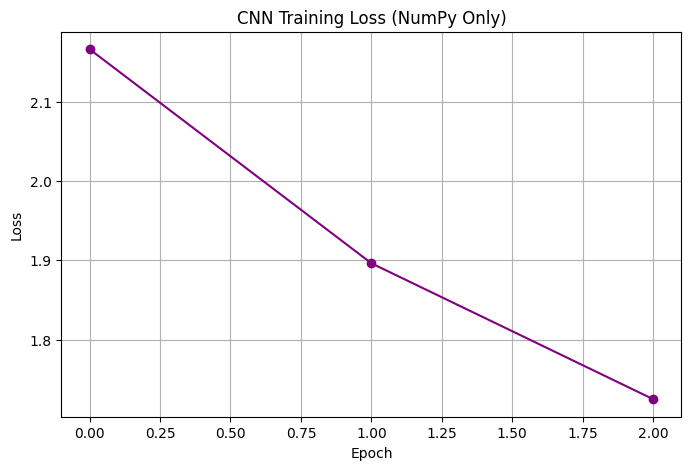

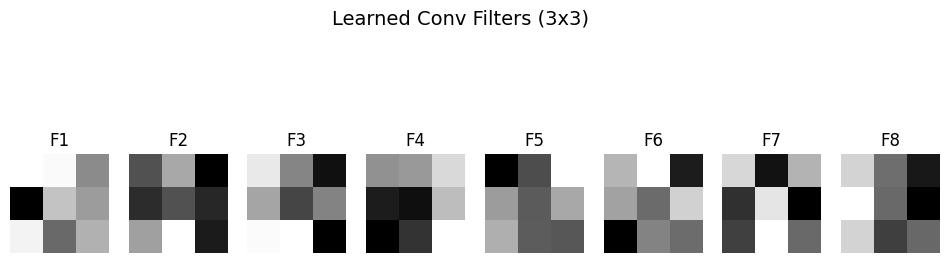


--- Running Inference on Test Samples ---


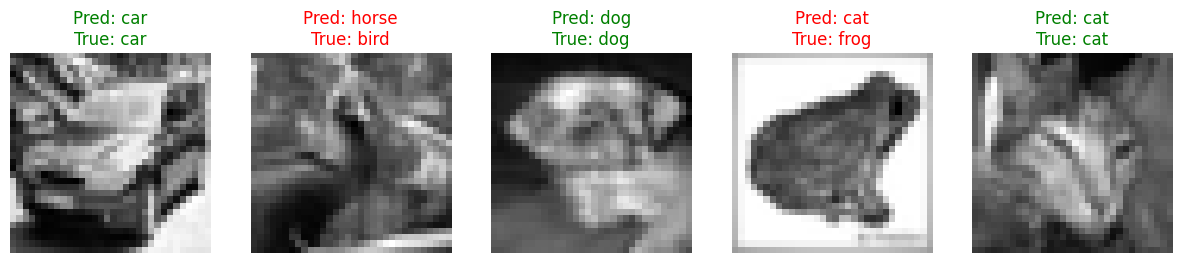

Test Subset Accuracy: 35.80%


In [8]:
# --- 5. Visualizations & Evaluation ---

# A. Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(loss_history, marker='o', color='purple')
plt.title("CNN Training Loss (NumPy Only)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# B. Visualize Learned Filters
# We access the first layer (Conv2D) weights: Shape (3, 3, 1, 8)
filters = cnn.layers[0].W
num_filters = 8

plt.figure(figsize=(12, 4))
plt.suptitle("Learned Conv Filters (3x3)", fontsize=14)
for i in range(num_filters):
    f = filters[:, :, 0, i] # Get ith filter
    plt.subplot(1, 8, i+1)
    plt.imshow(f, cmap='gray')
    plt.axis('off')
    plt.title(f"F{i+1}")
plt.show()

# C. Inference on Test Set
print("\n--- Running Inference on Test Samples ---")
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Pick 5 random images
indices = np.random.randint(0, X_test.shape[0], 5)
X_sample = X_test[indices]
Y_sample = np.argmax(Y_test[indices], axis=1)

# Predict
probs = cnn.forward(X_sample)
preds = np.argmax(probs, axis=1)

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # Reshape back to 2D for plotting
    img = X_sample[i].reshape(32, 32)
    plt.imshow(img, cmap='gray')

    color = 'green' if preds[i] == Y_sample[i] else 'red'
    plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[Y_sample[i]]}", color=color)
    plt.axis('off')
plt.show()

# Calculate Accuracy on Test Subset
test_probs = cnn.forward(X_test)
test_preds = np.argmax(test_probs, axis=1)
test_true = np.argmax(Y_test, axis=1)
acc = np.mean(test_preds == test_true) * 100
print(f"Test Subset Accuracy: {acc:.2f}%")

--- Starting High-Performance Training ---
Images: 5000 | Epochs: 12 | Batch: 64
Architecture: Conv(16) -> Dense(128) -> Output(10)

Epoch 1/12 | Loss: 2.2948 | Train Acc (est): 24.0%
Epoch 2/12 | Loss: 1.9397 | Train Acc (est): 31.5%
Epoch 3/12 | Loss: 1.8021 | Train Acc (est): 32.0%
Epoch 4/12 | Loss: 1.7095 | Train Acc (est): 41.0%
Epoch 5/12 | Loss: 1.5911 | Train Acc (est): 39.0%
Epoch 6/12 | Loss: 1.5194 | Train Acc (est): 42.5%
Epoch 7/12 | Loss: 1.4613 | Train Acc (est): 48.0%
Epoch 8/12 | Loss: 1.3931 | Train Acc (est): 45.5%
Epoch 9/12 | Loss: 1.3427 | Train Acc (est): 49.5%
Epoch 10/12 | Loss: 1.2822 | Train Acc (est): 51.0%
Epoch 11/12 | Loss: 1.2487 | Train Acc (est): 54.5%
Epoch 12/12 | Loss: 1.1877 | Train Acc (est): 56.5%

--- Final Evaluation ---
FINAL TEST ACCURACY: 46.40%


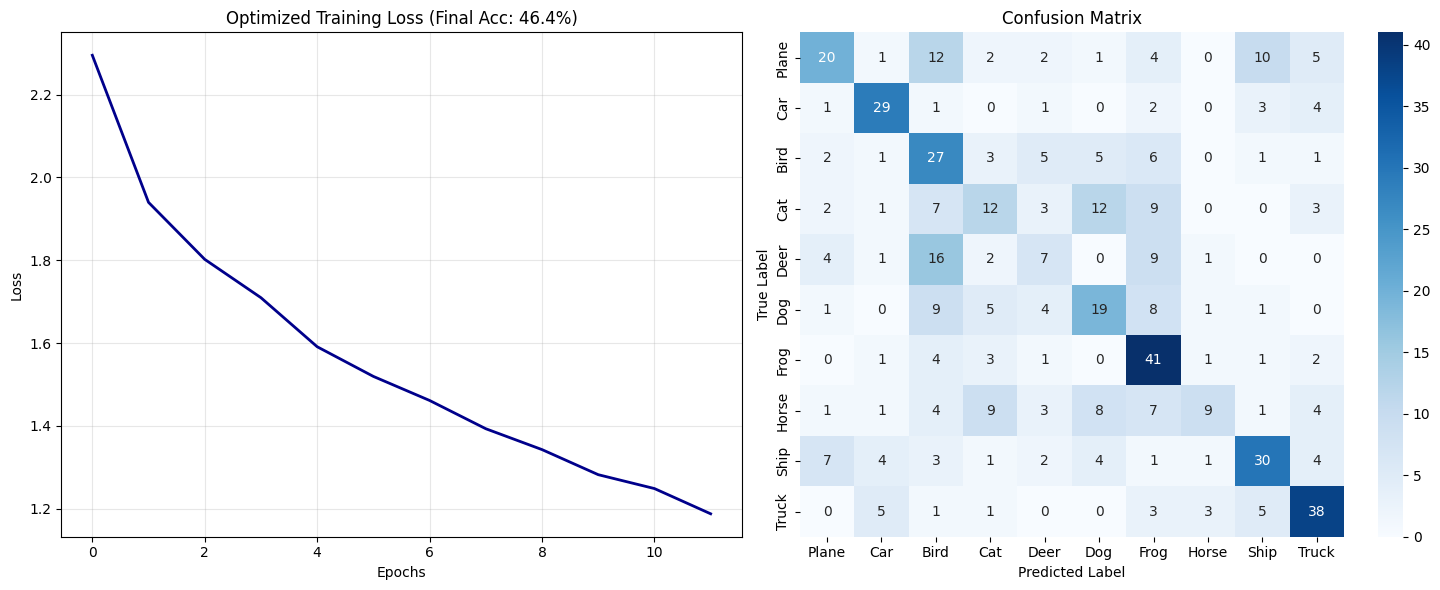

Best model saved.


In [9]:
# --- PART 6: High-Performance Optimization & Final Visualization ---
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Define the Optimized Architecture
class OptimizedCNN:
    def __init__(self):
        # Improved Architecture:
        # Conv(16 filters) -> ReLU -> MaxPool -> Dense(128) -> ReLU -> Dense(10)
        self.layers = [
            # Layer 0: Conv (Input 1 -> 16 filters)
            Conv2D(in_channels=1, out_channels=16, kernel_size=3, stride=1),
            # Layer 1: ReLU
            ReLU(),
            # Layer 2: MaxPool
            MaxPool2D(size=2, stride=2),
            # Layer 3: Flatten
            Flatten(),
            # Layer 4: Hidden Dense (16 * 15 * 15 = 3600 inputs -> 128 outputs)
            Dense(input_dim=16*15*15, output_dim=128),
            # Layer 5: ReLU
            ReLU(),
            # Layer 6: Output Dense (128 -> 10 classes)
            Dense(input_dim=128, output_dim=10)
        ]

    def forward(self, X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)

        # Softmax
        exp_z = np.exp(out - np.max(out, axis=1, keepdims=True))
        self.probs = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        return self.probs

    def backward(self, Y_one_hot):
        grad = (self.probs - Y_one_hot) / Y_one_hot.shape[0]

        grads_list = []
        for layer in reversed(self.layers):
            if isinstance(layer, (Conv2D, Dense)):
                grad, dW, db = layer.backward(grad)
                grads_list.append((dW, db))
            else:
                grad = layer.backward(grad)
                grads_list.append(None)

        return list(reversed(grads_list))

    def update_params(self, grads_list, lr=0.001, t=1):
        # Adam Optimizer
        beta1, beta2, epsilon = 0.9, 0.999, 1e-8

        for i, layer in enumerate(self.layers):
            if isinstance(layer, (Conv2D, Dense)):
                dW, db = grads_list[i]

                # Update W
                layer.v_W = beta1 * layer.v_W + (1-beta1) * dW
                layer.s_W = beta2 * layer.s_W + (1-beta2) * (dW**2)
                v_hat = layer.v_W / (1 - beta1**t)
                s_hat = layer.s_W / (1 - beta2**t)
                layer.W -= lr * v_hat / (np.sqrt(s_hat) + epsilon)

                # Update b
                layer.v_b = beta1 * layer.v_b + (1-beta1) * db
                layer.s_b = beta2 * layer.s_b + (1-beta2) * (db**2)
                v_hat_b = layer.v_b / (1 - beta1**t)
                s_hat_b = layer.s_b / (1 - beta2**t)
                layer.b -= lr * v_hat_b / (np.sqrt(s_hat_b) + epsilon)

# 2. Optimized Training Loop
def train_optimized(model, X_train, Y_train, epochs=12, batch_size=64):
    losses = []
    print(f"--- Starting High-Performance Training ---")
    print(f"Images: {X_train.shape[0]} | Epochs: {epochs} | Batch: {batch_size}")
    print("Architecture: Conv(16) -> Dense(128) -> Output(10)")
    print("WARNING: This involves heavy matrix operations. Please wait...\n")

    iter_count = 1
    for epoch in range(epochs):
        perm = np.random.permutation(X_train.shape[0])
        X_shuff = X_train[perm]
        Y_shuff = Y_train[perm]

        epoch_loss = 0
        num_batches = 0

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuff[i:i+batch_size]
            Y_batch = Y_shuff[i:i+batch_size]

            # Forward & Loss
            probs = model.forward(X_batch)
            loss = -np.sum(Y_batch * np.log(probs + 1e-15)) / batch_size
            epoch_loss += loss
            num_batches += 1

            # Backward & Update
            grads = model.backward(Y_batch)
            model.update_params(grads, lr=0.001, t=iter_count)
            iter_count += 1

            if i % 1500 == 0 and i > 0:
                print(f"   [Epoch {epoch+1}] Batch {i} processed...")

        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)

        # Check Train Accuracy on a small subset to track progress
        train_sample = X_train[:200]
        train_probs = model.forward(train_sample)
        train_acc = np.mean(np.argmax(train_probs, axis=1) == np.argmax(Y_train[:200], axis=1)) * 100

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Train Acc (est): {train_acc:.1f}%")

    return losses

# --- EXECUTION ---
# 1. Initialize
best_cnn = OptimizedCNN()

# 2. Train (12 epochs for maximum accuracy)
loss_history = train_optimized(best_cnn, X_train, Y_train, epochs=12, batch_size=64)

# 3. Final Evaluation
print("\n--- Final Evaluation ---")
test_probs = best_cnn.forward(X_test)
test_preds = np.argmax(test_probs, axis=1)
test_true = np.argmax(Y_test, axis=1)

final_acc = np.mean(test_preds == test_true) * 100
print(f"FINAL TEST ACCURACY: {final_acc:.2f}%")

# 4. Advanced Visualization
plt.figure(figsize=(15, 6))

# Plot A: Learning Curve
plt.subplot(1, 2, 1)
plt.plot(loss_history, linewidth=2, color='darkblue')
plt.title(f"Optimized Training Loss (Final Acc: {final_acc:.1f}%)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Plot B: Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(test_true, test_preds)
class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 5. Save Best Model
base_dir = 'submission_section3'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

with open(os.path.join(base_dir, 'best_cnn_optimized.pkl'), 'wb') as f:
    pickle.dump(best_cnn, f)

print("Best model saved.")

In [10]:
import os
import shutil
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import files

# --- PART 7: Generate & Download Supplementary Materials (Section 3) ---

print("Generating Final Materials for Section 3...")

# 1. Create Directory
base_dir = 'Supplementary_Materials_Section3_CNN'
if os.path.exists(base_dir):
    shutil.rmtree(base_dir) # Clean up
os.makedirs(base_dir)

# 2. Save the Trained Model (Best Optimized Version)
# 'best_cnn' is the object from Part 6
model_path = os.path.join(base_dir, 'cnn_model_numpy.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_cnn, f)
print(f"Saved model to {model_path}")

# 3. Save Visualizations (Re-generating to save as files)

# A. Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(loss_history, linewidth=2, color='darkblue')
plt.title(f"Training Loss Curve (Final Test Acc: {final_acc:.2f}%)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig(os.path.join(base_dir, '1_loss_curve.png'))
plt.close()

# B. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_true, test_preds)
class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(base_dir, '2_confusion_matrix.png'))
plt.close()

# C. Filter Visualization (Important Requirement)
# Get filters from the first layer
filters = best_cnn.layers[0].W # Shape: (3, 3, 1, 16)
num_filters = 16

plt.figure(figsize=(16, 3))
plt.suptitle(f"Learned Filters (First Conv Layer)", y=1.05)
for i in range(num_filters):
    f = filters[:, :, 0, i]
    plt.subplot(1, 16, i+1)
    plt.imshow(f, cmap='gray')
    plt.axis('off')
    plt.title(f"F{i+1}", fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, '3_learned_filters.png'))
plt.close()

# D. Sample Predictions
# Save a grid of 5 predictions
indices = np.random.randint(0, X_test.shape[0], 5)
X_sample = X_test[indices]
Y_sample_true = np.argmax(Y_test[indices], axis=1)
probs_sample = best_cnn.forward(X_sample)
preds_sample = np.argmax(probs_sample, axis=1)

plt.figure(figsize=(15, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = X_sample[i].reshape(32, 32)
    plt.imshow(img, cmap='gray')
    col = 'green' if preds_sample[i] == Y_sample_true[i] else 'red'
    plt.title(f"Pred: {class_names[preds_sample[i]]}\nTrue: {class_names[Y_sample_true[i]]}", color=col)
    plt.axis('off')
plt.savefig(os.path.join(base_dir, '4_test_predictions.png'))
plt.close()

# 4. Save Text Summary
with open(os.path.join(base_dir, 'results_summary.txt'), 'w') as f:
    f.write("Section 3: CNN from Scratch Results\n")
    f.write("===================================\n")
    f.write(f"Architecture: Conv(16) -> MaxPool -> Dense(128) -> Dense(10)\n")
    f.write(f"Optimizer: Adam\n")
    f.write(f"Epochs: 12\n")
    f.write(f"Final Test Accuracy: {final_acc:.2f}%\n")
    f.write("Note: Implemented using pure NumPy (no PyTorch/TensorFlow layers).")

# 5. Zip and Download
shutil.make_archive(base_dir, 'zip', base_dir)
print(f"Zipped folder created: {base_dir}.zip")

files.download(f"{base_dir}.zip")

Generating Final Materials for Section 3...
Saved model to Supplementary_Materials_Section3_CNN/cnn_model_numpy.pkl
Zipped folder created: Supplementary_Materials_Section3_CNN.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>